In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import torch
from scipy import sparse
import numpy as np
#import cupy as cp
from matplotlib import cm, colors
import netCDF4 as nc
import astropy.units as u
import dask
import os
from IPython.display import HTML
from matplotlib import animation, rc
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from matplotlib.image import NonUniformImage
import math
import time 
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

import muse as muse
from muse.synthesis.synthesis import vdem_synthesis, sum_lines_per_band, vdem_syn_join_slits_wvl, sum_lines_slits_per_band
from muse.utils.utils import calculate_moments, weight_func, deweight_func, sub_possitive
from muse.inversions.inversions import vdem_solve
from muse.transforms.transforms import muse_fov, reshape_x2rs, reshape_rs2x, muse_interp_xyw2rssg
from muse.instr.psf import calculate_psf, convolve_model_psf, deconvolve_model_psf, deconvolve_model_y_psf
from muse.instr.gausslobes import gausslobes
from xhistogram.xarray import histogram
#channel = {'FeXIX':108., 'FeXXI':108., 'FeIX':171., 'FeXV':284.}

plt.rcParams["image.origin"] = 'lower'
os.system('sudo mount -o discard,defaults /dev/sdc /mnt/disks/disk-6-kyuhyoun')
os.chdir('/mnt/disks/disk-6-kyuhyoun')

os.environ['EBYSUS'] = "/fakeEbysuspath"
os.environ['BIFROST'] = "/fakeEbysuspath"
os.environ['XUVTOP'] = "/home/jupyter/dbase"
os.environ['LMSALHUB'] = "/fakeXUVTOPpath"
os.environ['GOFT_PATH'] = "./"

# SELECT WHICH KIND OF CODE
# =========================
chosen_code = 'muram'
if chosen_code == 'pypluto': 
    import helita.sim.pypluto as chcode # Helita reads snapshots 
elif chosen_code == 'cipmocct': 
    import helita.sim.cipmocct as chcode
elif  chosen_code == 'laresav': 
    import helita.sim.laresav as chcode
elif  chosen_code == 'bifrost':  
    import helita.sim.bifrost as chcode
elif chosen_code == 'muram':
    import helita.sim.muram as chcode
elif chosen_code =='radyn':
    import helita.sim.radyn as chcode
elif chosen_code =='matsumoto':
    import helita.sim.matsumotosav as chcode

import br_py.tools as btr # Synthesis or VDEMs (including pycuda or pytorch)
import gcp_utils.gcp_dem as gcp # random functions (pool for adding code), includes VDEM with pytorch or numpy

mount: /mnt/disks/disk-6-kyuhyoun: /dev/sdc already mounted on /mnt/disks/disk-6-kyuhyoun.


br_uvrt is not imported, pycuda.autoinit import failed
br_dem is not imported, pycuda.autoinit import failed
GOFT_PATH try ./
(WWW) selected file 'mhd.in' is not available. Setting the following Default Solar Bifrost units:  {'u_l': 100000000.0, 'u_t': 100.0, 'u_r': 1e-07, 'gamma': 1.667}


In [2]:
# select test case 
basename = ''
if chosen_code == 'pypluto': 
    bdir='wave_models/Pluto_TomVD/simulation_karampelas' # GCP/bucket path
    snap=170                                             # snapshot number
    basename='data'
    snapname=basename+'.{:04d}'.format(snap)
    
elif chosen_code == 'cipmocct': 
    bdir='wave_models/khi/oscloop-test'
    snap=217
    basename='oschp01la8e3v0a1nosym_ugr_3d'
    snapname=basename+'_{:04d}'.format(snap)
    
elif  chosen_code == 'laresav': 
    bdir='wave_models/Ineke-Lare/test_idlsave_format'
    snap=350
    snapname='{:03d}'.format(snap)+'.sav'
    
elif  chosen_code == 'bifrost':     
    bdir='bifrost/nw072100_alt'
    #bdir='bifrost/nw072100'
    snap=622
    snap=437
    snap=620
    basename='nw072100'
    snapname=basename+'_{:03d}'.format(snap)

elif chosen_code == 'muram':
    bdir='muram/plage'
    snap = 317600 # snapshot number
    snapname0 = 'result_prim_0'
    iz0=320
    bdir='muram/hgcr'
    snap = 294000 # snapshot number
    iz0=125
    snapname = '.{:07d}'.format(snap)
    
elif chosen_code == 'radyn':
    bdir='1d_models/radyn_test'
    snapname = 'radyn_out.cdf'
 
elif chosen_code == 'matsumoto': 
    bdir='wave_models/Matsumoto2018'
    snap=250
    basename='f'
    snapname=basename+'{:06d}'.format(snap)+'.sav'
    print(snapname)

In [3]:
code_list={}
##code_list['radyn'] = ['test']
##code_list['pypluto'] = ['kosta','paolo']
#code_list['bifrost'] = ['qs','ch','hion','fe']
#code_list['bifrost'] = ['hion','fe','ch']
#code_list['bifrost'] = ['nw']
#code_list['bifrost'] = ['ch','fe','hion']
#code_list['muram']   = ['lowres_hpm','lowres_lpm','highres_lpm']
#code_list['muram']   = ['highres_lpm','plage','peacock','emergence']
code_list['muram']   = ['hgcr']
#code_list['muram']   = ['emergence']
#code_list['pypluto'] = ['kosta']
#code_list['laresav'] = ['ac_ha_hgb','ac_ha_cold']
#code_list['laresav'] = ['muse_dc_highamp','muse_ac_highamp']
#code_list['matsumoto'] = ['test']
#code_list['cipmocct'] = ['test']
#code_list['pypluto'] = ['kosta']
nsim=2

In [4]:
# importing MUSE response functions (nc files). Computed previously with Adrian's IDL code. 
# file_C_nc: Contaminants only and file_L_nc: main lines. 
# =================================================
UPSAVE = False
file_C_nc = ["respfunc1-108-L.nc","respfunc1-171-L.nc","respfunc1-284-L.nc"]
file_L_nc = ["respfunc1-FeXIX.nc","respfunc1-FeIX.nc","respfunc1-FeXV.nc","respfunc1-FeXXI.nc"]
if UPSAVE: 
    for ifile in file_C_nc:
        bal=gcp.download_from_bucket(ifile,bucket_name="muse_response_function")
    for ifile in file_L_nc:
        bal=gcp.download_from_bucket(ifile,bucket_name="muse_response_function")

In [5]:
# V1a: Compute a VDEM(logT,vdop, x, y) cube. 
recompute = True
losaxis=2
timeint=1.5

ddbtr=btr.UVOTRTData(template=snapname,prim=snapname0,fdir='./',iz0=iz0,_class=chosen_code) 

tg=ddbtr.trans2comm('tg')
uz=ddbtr.trans2comm('uz')/1e5 # cm/s -> km/s We use in from_hel2vdem km/s
ntg=int(((np.max(np.log10(tg))-np.min(np.log10(tg)))*10 + 1)/2)
uzmax=np.max(np.abs(uz))*2/3
uzmax=400
nvel=int(uzmax/10 + 1) # in km/s
print(nvel)

#This test selects 0.1 LogT/K bin size and 10km/s velocity (like for the available response functions). This could be improved eventually. 
ntg=26
lgtaxis = np.linspace(5.0,7.5,ntg)
syn_dopaxis = np.linspace(-np.max(np.abs(uz))/3,np.max(np.abs(uz))/3,nvel) 
syn_dopaxis = np.linspace(-400,400,41)

#gcp.download_sims(code,simu,snap)
vdem = ddbtr.from_hel2vdem(snap, syn_dopaxis, lgtaxis, axis=losaxis, xyrotation=True)
#vdem

(WWW) selected file 'None' is not available. Setting the following Default Solar Bifrost units:  {'u_l': 100000000.0, 'u_t': 100.0, 'u_r': 1e-07, 'gamma': 1.667}
41* Read EOS table from .//eostable.dat         
(WWW) tab_interp: Ei outside of table bounds. Table Ei min=1496509210000.00, requested Ei min=999999930368.00
(WWW) tab_interp: Ei outside of table bounds. Table Ei max=1046017770000000.00, requested Ei max=55797066898604032.00


CPU times: user 5.87 s, sys: 3.58 s, total: 9.44 s
Wall time: 9.44 s


<xarray.Dataset>
Dimensions:  (logT: 26, vdop: 41, y: 404, x: 407)
Coordinates:
  * logT     (logT) float64 5.0 5.1 5.2 5.3 5.4 5.5 ... 7.0 7.1 7.2 7.3 7.4 7.5
  * vdop     (vdop) float64 -400.0 -380.0 -360.0 -340.0 ... 360.0 380.0 400.0
  * x        (x) float64 0.0 0.401 0.802 1.203 1.604 ... 161.6 162.0 162.4 162.8
  * y        (y) float64 0.0 0.1674 0.3348 0.5022 ... 66.97 67.13 67.3 67.47
Data variables:
    vdem     (logT, vdop, y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    HISTORY:  ['muse_fov(vdem, dx_pix=0.4, dy_pix=0.167, nslits=37, nraster=1...
    version:  0.1.dev29+g2103bc1.d20230424

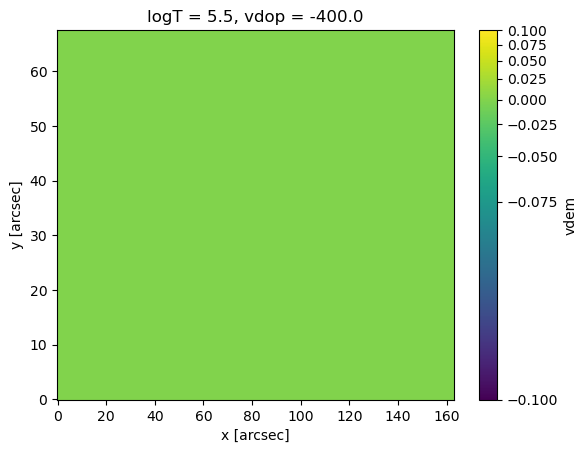

In [6]:
%%time
# V1A+: Puts the VDEM in MUSE spatial resolution and bin size. 
# Several options (tiling, or making zeros, or fakely change the bin size of the simulation among others)
vdem2 = muse_fov(vdem)
vdem2.vdem.isel(logT=5,vdop=0).plot.imshow(norm=colors.PowerNorm(0.3))
save=False
if save: 
    vdem2.to_zarr("test")
vdem2

In [7]:
vdem3 = reshape_x2rs(vdem2)

In [8]:
%%time
# Reading MUSE response functions (main and contaminants)
# The following "with" statement is just to silence dask's warning about big chunks used to store Adrian's response functions
from muse.utils.utils import read_response
with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    response = read_response('respfunc0-FeXIX.zarr', logT=vdem3.logT, vdop=vdem3.vdop, slit=vdem3.slit)
    response = xr.concat([response,read_response('respfunc0-FeXXI.zarr', logT=vdem3.logT, vdop=vdem3.vdop, slit=vdem3.slit)],dim='line')
    response = xr.concat([response,read_response('respfunc0-108-L.zarr', logT=vdem3.logT, vdop=vdem3.vdop, slit=vdem3.slit)],dim='line')
    response = xr.concat([response,read_response('respfunc0-FeIX.zarr', logT=vdem3.logT, vdop=vdem3.vdop, slit=vdem3.slit)],dim='line')
    response = xr.concat([response,read_response('respfunc0-171-L.zarr', logT=vdem3.logT, vdop=vdem3.vdop, slit=vdem3.slit)],dim='line')
    response = xr.concat([response,read_response('respfunc0-FeXV.zarr', logT=vdem3.logT, vdop=vdem3.vdop, slit=vdem3.slit)],dim='line')
    response = xr.concat([response,read_response('respfunc0-284-L.zarr', logT=vdem3.logT, vdop=vdem3.vdop, slit=vdem3.slit)],dim='line')
    response = response.assign_coords(band = ('line', [108,108,108,171,171,284,284]))

response

CPU times: user 351 ms, sys: 34.5 ms, total: 385 ms
Wall time: 463 ms


<xarray.Dataset>
Dimensions:    (vdop: 41, logT: 26, line: 7, slit: 37, SG_xpixel: 1024)
Coordinates:
  * vdop       (vdop) float64 -400.0 -380.0 -360.0 -340.0 ... 360.0 380.0 400.0
  * logT       (logT) float64 5.0 5.1 5.2 5.3 5.4 5.5 ... 7.1 7.2 7.3 7.4 7.5
  * SG_xpixel  (SG_xpixel) int32 0 1 2 3 4 5 6 ... 1018 1019 1020 1021 1022 1023
  * slit       (slit) int32 0 1 2 3 4 5 6 7 8 9 ... 28 29 30 31 32 33 34 35 36
  * line       (line) <U17 'Fe XIX' 'Fe XXI' ... 'Fe XV' 'Fe XV is missing'
    band       (line) int64 108 108 108 171 171 284 284
Data variables:
    SG_resp    (line, vdop, logT, slit, SG_xpixel) float32 dask.array<chunksize=(1, 1, 26, 37, 1024), meta=np.ndarray>
    SG_wvl     (line, slit, SG_xpixel) float32 dask.array<chunksize=(1, 37, 1024), meta=np.ndarray>
    line_wvl   (line) float64 108.4 108.1 108.4 171.1 171.1 284.2 284.2
Attributes: (12/15)
    ABUNDANCES:    sun_coronal_1992_feldman_ext.abund
    BAND_CUBES:    band_cubes_569lines_p3e15_coronal_to2000kms-26Mar2021.sav
    DESCRIPTION:   test
    EFF_AREA:      SMX00044 muse_response_20160811.sav
    E_PRESSURE:    3000000028082176.0
    GOFT_FILE:     goft_p3e15-6Mar2021.sav
    ...            ...
    SG_BAND:       108
    SLIT_SEP_A:    0.39004001021385193
    SLIT_SEP_PIX:  26.53333282470703
    SLIT_WID_PIX:  2.3333332538604736
    UNITS:         photon counts/s from EM=10^27(cm^-5) at Log10(T/K), VDOP(k...
    VERSION:       made using muse-v1f.pro, Fri Mar 26 20:01:03 2021, mult304...

In [9]:
%%time
# 5A->F6A*: Convert SG_xpixel into SG_wvl and combining slits 4 and 34 because every 15 slits the 
# SG pixel match in wvl size. 4 and 34 to have the most left and righ pixels and multiple of 15. 
# So no PSF yet! 
# (slide)
save=False
spec_merge_line = vdem_syn_join_slits_wvl(response,vdem2)
if save: 
    spec_merge_line.to_zarr("test")
spec_merge_line

CPU times: user 2min 9s, sys: 20.1 s, total: 2min 29s
Wall time: 1min 1s


<xarray.Dataset>
Dimensions:   (band: 3, y: 404, x: 407, wvl_pix: 1829)
Coordinates:
  * wvl_pix   (wvl_pix) float64 0.0 1.0 2.0 ... 1.826e+03 1.827e+03 1.828e+03
  * y         (y) float64 0.0 0.1674 0.3348 0.5022 ... 66.97 67.13 67.3 67.47
  * x         (x) float64 0.0 0.401 0.802 1.203 ... 161.6 162.0 162.4 162.8
  * band      (band) int64 108 171 284
    SG_wvl    (band, wvl_pix) float64 94.42 94.44 94.45 ... 310.0 310.0 310.1
Data variables:
    flux      (band, y, x, wvl_pix) float64 2.726e-09 2.598e-09 ... 4.19e-07
    line_wvl  (band) float64 324.8 342.1 568.3
Attributes: (12/17)
    ABUNDANCES:    sun_coronal_1992_feldman_ext.abund
    BAND_CUBES:    band_cubes_569lines_p3e15_coronal_to2000kms-26Mar2021.sav
    DESCRIPTION:   test
    EFF_AREA:      SMX00044 muse_response_20160811.sav
    E_PRESSURE:    3000000028082176.0
    GOFT_FILE:     goft_p3e15-6Mar2021.sav
    ...            ...
    SLIT_SEP_PIX:  26.53333282470703
    SLIT_WID_PIX:  2.3333332538604736
    UNITS:         photon counts/s from EM=10^27(cm^-5) at Log10(T/K), VDOP(k...
    VERSION:       made using muse-v1f.pro, Fri Mar 26 20:01:03 2021, mult304...
    HISTORY:       ['muse_fov(vdem, dx_pix=0.4, dy_pix=0.167, nslits=37, nras...
    version:       0.1.dev29+g2103bc1.d20230424

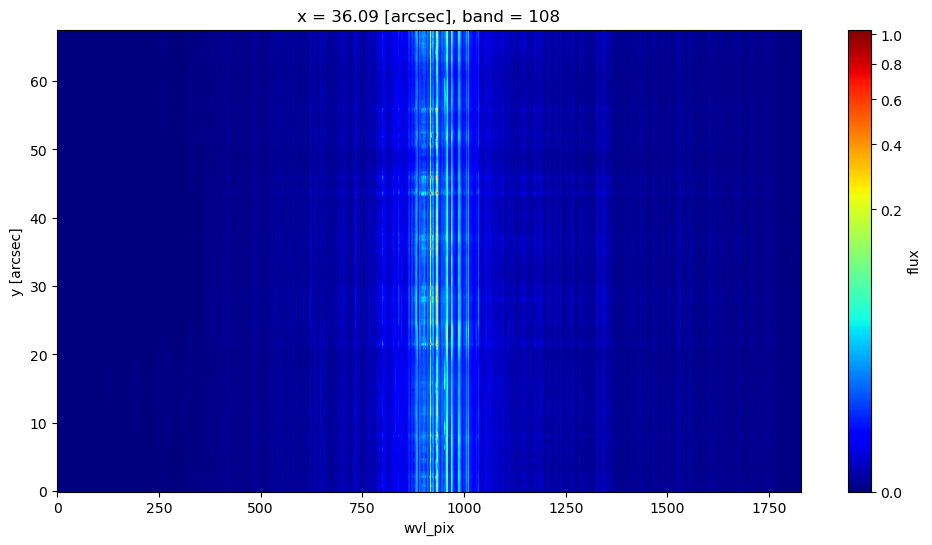

In [10]:
spec_merge_line.flux.isel(band=0,x=90).plot.imshow(norm=colors.PowerNorm(0.3), cmap='jet', figsize=(12,6))

### We have different filters that we are investigating best options 

In [32]:
%%time
# 5A->F6A: Convolve with the PSF (chromatic option). 
#kargs={"overx": 1, "cubey": 202}
kargs={"oversample_x": 3, "slit_dim": 404}
spec_with_psf = convolve_model_psf(spec_merge_line,model=gausslobes,**kargs, band=[284])
spec_with_psf = convolve_model_psf(spec_with_psf,model=gausslobes,**kargs, band=[108,171],only_core=True)

#only_psf = convolve_model_psf(spec_merge_line,model=gausslobes,**kargs, band=[284],no_core=True)

save=False
if save: 
    spec_with_psf.to_zarr("test")
spec_with_psf

CPU times: user 14min 43s, sys: 36.4 s, total: 15min 19s
Wall time: 7min 10s


<xarray.Dataset>
Dimensions:   (band: 3, y: 404, x: 407, wvl_pix: 1829)
Coordinates:
  * wvl_pix   (wvl_pix) float64 0.0 1.0 2.0 ... 1.826e+03 1.827e+03 1.828e+03
  * y         (y) float64 0.0 0.1674 0.3348 0.5022 ... 66.97 67.13 67.3 67.47
  * x         (x) float64 0.0 0.401 0.802 1.203 ... 161.6 162.0 162.4 162.8
  * band      (band) int64 108 171 284
    SG_wvl    (band, wvl_pix) float64 94.42 94.44 94.45 ... 310.0 310.0 310.1
Data variables:
    flux      (x, y, band, wvl_pix) float64 1.19e-09 1.134e-09 ... 2.543e-07
    line_wvl  (band) float64 324.8 342.1 568.3
Attributes: (12/17)
    ABUNDANCES:    sun_coronal_1992_feldman_ext.abund
    BAND_CUBES:    band_cubes_569lines_p3e15_coronal_to2000kms-26Mar2021.sav
    DESCRIPTION:   test
    EFF_AREA:      SMX00044 muse_response_20160811.sav
    E_PRESSURE:    3000000028082176.0
    GOFT_FILE:     goft_p3e15-6Mar2021.sav
    ...            ...
    SLIT_SEP_PIX:  26.53333282470703
    SLIT_WID_PIX:  2.3333332538604736
    UNITS:         photon counts/s from EM=10^27(cm^-5) at Log10(T/K), VDOP(k...
    VERSION:       made using muse-v1f.pro, Fri Mar 26 20:01:03 2021, mult304...
    HISTORY:       ['muse_fov(vdem, dx_pix=0.4, dy_pix=0.167, nslits=37, nras...
    version:       0.1.dev29+g2103bc1.d20230424

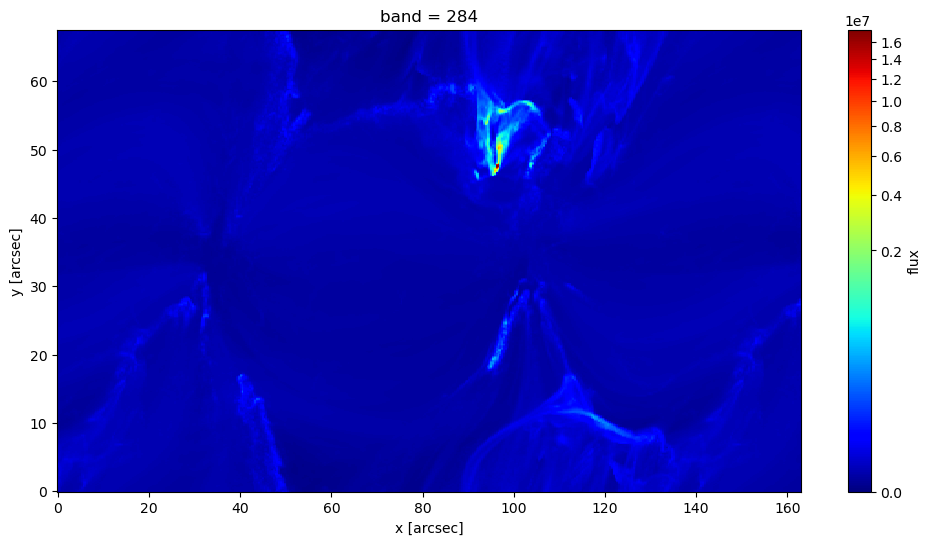

In [33]:
spec_merge_line.flux.isel(band=2).sum(dim=['wvl_pix']).transpose('y','x').plot.imshow(norm=colors.PowerNorm(0.3), cmap='jet', figsize=(12,6))

In [34]:
spec_only_core = convolve_model_psf(spec_merge_line,model=gausslobes,**kargs, band=[108,171,284],only_core=[True]*3)
muse_only_core, resp = muse_interp_xyw2rssg(spec_only_core,response)

KeyboardInterrupt: 

In [35]:
specsum_only_core = sum_lines_slits_per_band(muse_only_core)

MemoryError: Unable to allocate 1.25 GiB for an array with shape (37, 11, 404, 1024) and data type float64

In [ ]:
%%time
# 7A->M8: Back to the steped we did before but now includes the PSF
# interpolate SG_wvl into SG_xpixel for each slit 
# SG pixel match in wvl size. 4 and 34 to have the most left and righ pixels and multiple of 15. 
# (slide)
muse_spect_psf, resp = muse_interp_xyw2rssg(spec_with_psf,response)
#muse_spect, resp = muse_interp_xyw2rssg(spec_merge_line, response)

In [39]:
muse_spect, resp = muse_interp_xyw2rssg(spec_merge_line, response)
specsum = sum_lines_slits_per_band(muse_spect)

MemoryError: Unable to allocate 6.72 GiB for an array with shape (3, 404, 1829, 37, 11) and data type float64

In [36]:
%%time
# 7A->M8: now summing all slits. 
# This step provides the response and spectrum ready to run the disambiguation code
#specsum = sum_lines_slits_per_band(muse_spect)
respsum = sum_lines_per_band(resp)
specsum_psf = sum_lines_slits_per_band(muse_spect_psf)
if True:
    specsum_psf.to_netcdf("specsum_psf.nc", mode="w")

CPU times: user 1.57 s, sys: 978 ms, total: 2.55 s
Wall time: 3.11 s


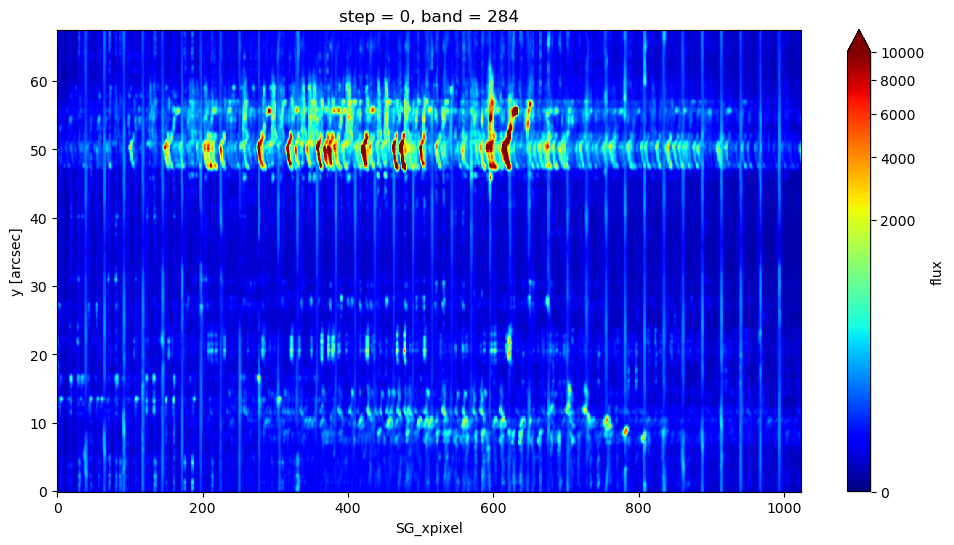

In [37]:
specsum_psf.flux.isel(band=2,step=0).plot.imshow(norm=colors.PowerNorm(0.3), cmap='jet', figsize=(12,6),vmin=0,vmax=1e4)

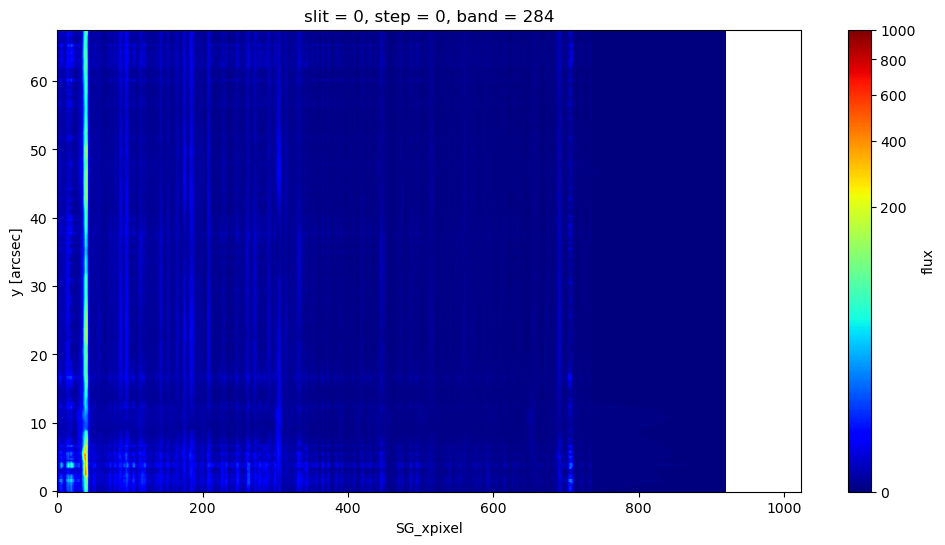

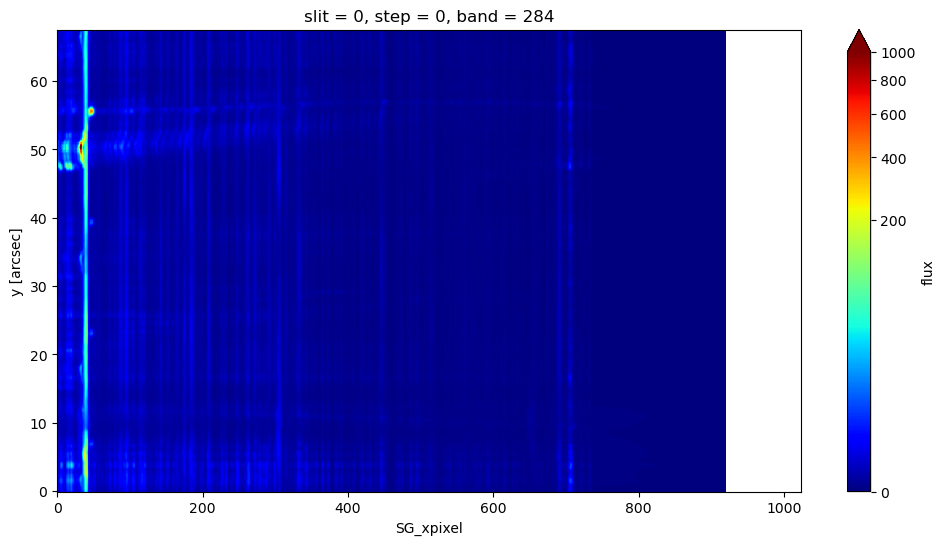

In [22]:
muse_spect.flux.isel(band=2,step=0,slit=0).plot.imshow(norm=colors.PowerNorm(0.3), cmap='jet', figsize=(12,6),vmin=0,vmax=1e3)
muse_spect_psf.flux.isel(band=2,step=0,slit=0).plot.imshow(norm=colors.PowerNorm(0.3), cmap='jet', figsize=(12,6),vmin=0,vmax=1e3)

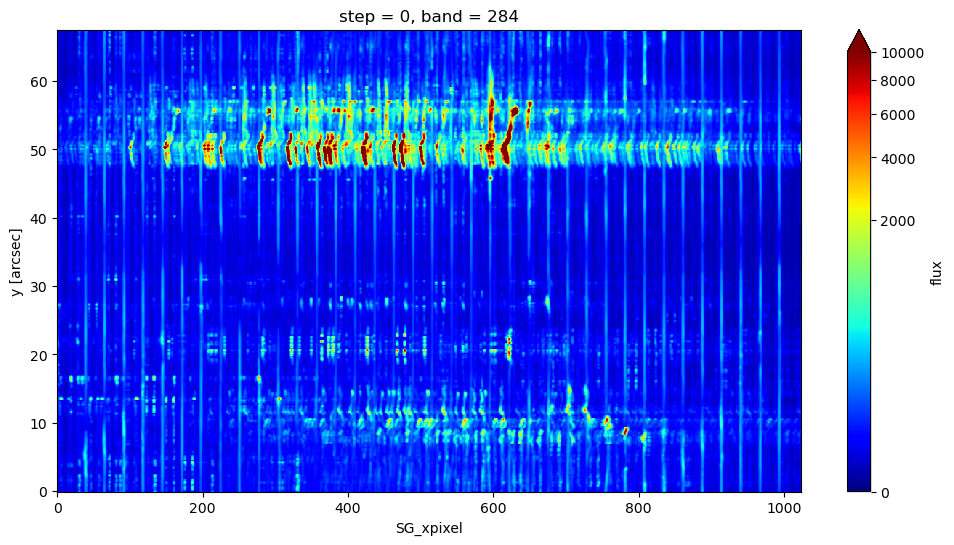

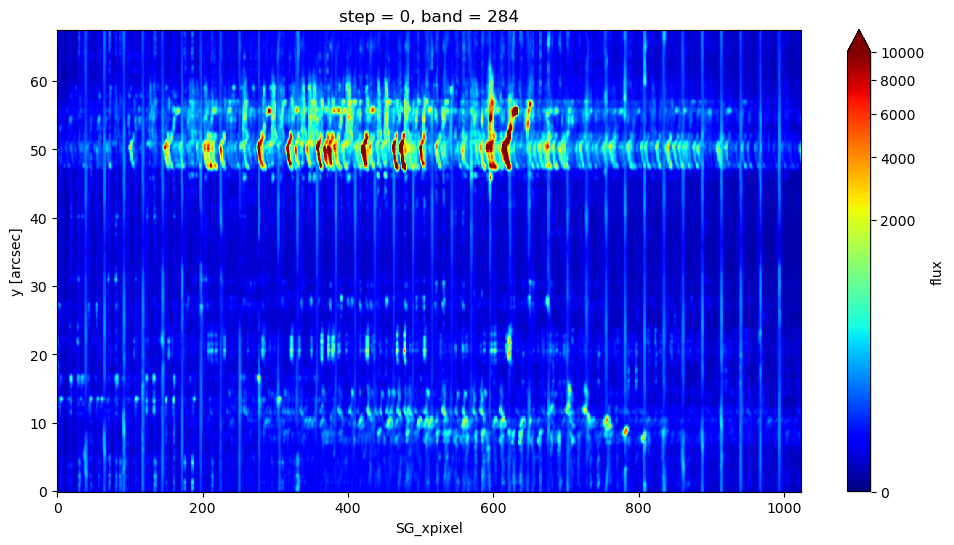

In [23]:
muse_spect.flux.isel(band=2,step=0).sum(dim=['slit']).plot.imshow(norm=colors.PowerNorm(0.3), cmap='jet', figsize=(12,6),vmin=0,vmax=1.e4)
muse_spect_psf.flux.isel(band=2,step=0).sum(dim=['slit']).plot.imshow(norm=colors.PowerNorm(0.3), cmap='jet', figsize=(12,6),vmin=0,vmax=1e4)

In [24]:
muse_spect

<xarray.Dataset>
Dimensions:    (slit: 37, step: 11, y: 404, SG_xpixel: 1024, band: 3)
Coordinates:
  * slit       (slit) int64 0 1 2 3 4 5 6 7 8 9 ... 28 29 30 31 32 33 34 35 36
  * step       (step) int64 0 1 2 3 4 5 6 7 8 9 10
  * y          (y) float64 0.0 0.1674 0.3348 0.5022 ... 66.97 67.13 67.3 67.47
  * SG_xpixel  (SG_xpixel) int32 0 1 2 3 4 5 6 ... 1018 1019 1020 1021 1022 1023
  * band       (band) int64 108 171 284
Data variables:
    flux       (band, slit, step, y, SG_xpixel) float64 0.05911 ... 0.002235
    line_wvl   (band) float64 108.4 171.1 284.2
Attributes: (12/20)
    ABUNDANCES:       sun_coronal_1992_feldman_ext.abund
    BAND_CUBES:       band_cubes_569lines_p3e15_coronal_to2000kms-26Mar2021.sav
    DESCRIPTION:      test
    EFF_AREA:         SMX00044 muse_response_20160811.sav
    E_PRESSURE:       3000000028082176.0
    GOFT_FILE:        goft_p3e15-6Mar2021.sav
    ...               ...
    VERSION:          made using muse-v1f.pro, Fri Mar 26 20:01:03 2021, mult...
    HISTORY:          ['muse_fov(vdem, dx_pix=0.4, dy_pix=0.167, nslits=37, n...
    version:          0.1.dev10+ge741e21
    flux units:       ph/s
    step_size:        0.4009852216748769
    step_size units:  arcsec

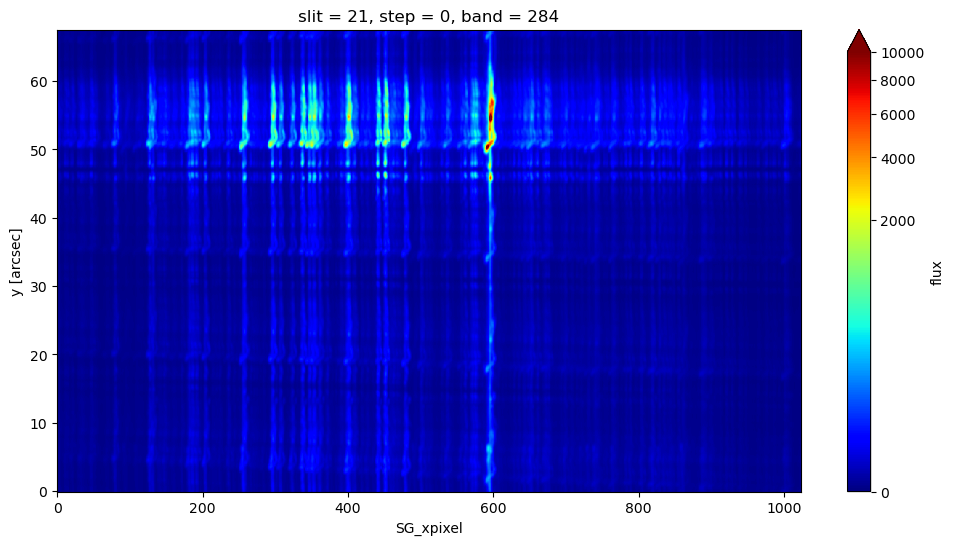

In [25]:
muse_spect_psf.flux.isel(band=2,step=0,slit=21).plot.imshow(norm=colors.PowerNorm(0.3), cmap='jet', figsize=(12,6),vmin=0,vmax=1e4)

In [26]:
from sklearn.linear_model import LassoLars as LassoLars
def full_apprach(vdem, resp, func_list,nsteps=1): 
    for it in range(nsteps):
        print(it)
        for ifunc in func_list: 
            print(ifunc.split("&")[1])
            if ifunc.split("&")[0] == "vdem ":
                vdem = eval(ifunc.split("&")[1])
            elif ifunc.split("&")[0] == "spec ":
                try: 
                    print(spec)
                except: 
                    print('none')
                spec = eval(ifunc.split("&")[1])
            elif ifunc.split("&")[0] == "spec, resp ":
                spec, resp  = eval(ifunc.split("&")[1])
            elif ifunc.split("&")[0] == "sol ":
                sol = eval(ifunc.split("&")[1])
            elif ifunc.split("&")[0] == "spec, resp, sol ":
                spec, resp, sol = eval(ifunc.split("&")[1])
    return spec, resp, sol

def adrian_apprach(spec, resp, func_list,nsteps=1): 
    spec_orig = spec.copy()
    for it in range(nsteps):
        print(it)
        for ifunc in func_list: 
            print(ifunc)
            if ifunc.split("&")[0] == "vdem ":
                vdem = eval(ifunc.split("&")[1])
            elif ifunc.split("&")[0] == "spec ":
                spec = eval(ifunc.split("&")[1])
            elif ifunc.split("&")[0] == "spec.flux ":
                spec.flux = eval(ifunc.split("&")[1])
            elif ifunc.split("&")[0] == "respsum.SG_resp ":
                respsum['SG_resp'].loc[dict(band=284)] = respsum['SG_resp'].loc[dict(band=284)]*(0.81**2)
            elif ifunc.split("&")[0] == "spec, resp ":
                spec, resp  = eval(ifunc.split("&")[1])
            elif ifunc.split("&")[0] == "spec, respsum ":
                spec, respsum  = eval(ifunc.split("&")[1])
            elif ifunc.split("&")[0] == "spec, respsum, sol ":
                spec, respsum, sol  = eval(ifunc.split("&")[1])
            elif ifunc.split("&")[0] == "diff_pat, resp ":
                diff_pat, resp  = eval(ifunc.split("&")[1])
            elif ifunc.split("&")[0] == "sol ":
                sol = eval(ifunc.split("&")[1])
            elif ifunc.split("&")[0] == "respsum ":
                respsum = eval(ifunc.split("&")[1])
            elif ifunc.split("&")[0] == "diff_pat ":
                diff_pat = eval(ifunc.split("&")[1])
            elif ifunc.split("&")[0] == "spec, resp, sol ":
                spec, resp, sol = eval(ifunc.split("&")[1])
            else: 
                eval(ifunc)
    return spec, resp, sol


def adrian2_apprach(spec, resp, sol, spec_orig, func_list,nsteps=1): 
    for it in range(nsteps):
        print(it)
        for ifunc in func_list: 
            print(ifunc)
            if ifunc.split("&")[0] == "vdem ":
                vdem = eval(ifunc.split("&")[1])
            elif ifunc.split("&")[0] == "spec ":
                spec = eval(ifunc.split("&")[1])
            elif ifunc.split("&")[0] == "spec.flux ":
                spec["flux"] = eval(ifunc.split("&")[1])
            elif ifunc.split("&")[0] == "respsum.SG_resp ":
                respsum['SG_resp'].loc[dict(band=284)] = respsum['SG_resp'].loc[dict(band=284)]*(0.81**2)
            elif ifunc.split("&")[0] == "spec, resp ":
                spec, resp  = eval(ifunc.split("&")[1])
            elif ifunc.split("&")[0] == "spec, respsum ":
                spec, respsum  = eval(ifunc.split("&")[1])
            elif ifunc.split("&")[0] == "spec, respsum, sol ":
                spec, respsum, sol  = eval(ifunc.split("&")[1])
            elif ifunc.split("&")[0] == "diff_pat, resp ":
                diff_pat, resp  = eval(ifunc.split("&")[1])
            elif ifunc.split("&")[0] == "sol ":
                sol = eval(ifunc.split("&")[1])
            elif ifunc.split("&")[0] == "respsum ":
                respsum = eval(ifunc.split("&")[1])
            elif ifunc.split("&")[0] == "diff_pat ":
                diff_pat = eval(ifunc.split("&")[1])
            elif ifunc.split("&")[0] == "spec, resp, sol ":
                spec, resp, sol = eval(ifunc.split("&")[1])
            else: 
                eval(ifunc)
    return spec, resp, sol

In [27]:
# Disambiguation without any trick on the diffraction. 
func_list = [
    # preparing response function  (summing lines)
    "respsum & sum_lines_per_band(resp)",
    "respsum.SG_resp & respsum.SG_resp*0.81**2",
    # preparing for disambiguation (some normalization between bands)
    "spec, respsum & weight_func(spec, respsum, fact = {0: 0.10, 1: 5., 2: 2.})", 
    # disambiguation
    "sol & vdem_solve(spec, respsum, model = LassoLars(alpha=1.e-3, fit_intercept=True, normalize=True, eps=np.finfo(float).eps))",
    # remove the normalization between bands
    "spec, respsum, sol & deweight_func(spec, respsum, sol, fact = {0: 0.10, 1: 5., 2: 2.})",
]
spec_psf_a, resp_a, sol_psf_a = adrian_apprach(specsum_psf, response, func_list)

0
respsum & sum_lines_per_band(resp)
respsum.SG_resp & respsum.SG_resp*0.81**2
spec, respsum & weight_func(spec, respsum, fact = {0: 0.10, 1: 5., 2: 2.})
5.986727290862106e+32 <xarray.DataArray 'SG_resp' ()>
array(9.7431755, dtype=float32)
Coordinates:
    band     int64 284
sol & vdem_solve(spec, respsum, model = LassoLars(alpha=1.e-3, fit_intercept=True, normalize=True, eps=np.finfo(float).eps))


100%|██████████| 4444/4444 [5:10:02<00:00,  4.19s/it]  


spec, respsum, sol & deweight_func(spec, respsum, sol, fact = {0: 0.10, 1: 5., 2: 2.})
1197345.4581724212 <xarray.DataArray 'SG_resp' ()>
array(19.486351, dtype=float32)
Coordinates:
    band     int64 284


In [29]:
# Compute some "fake" diffraction pattern and substract from the original data. 
func_list = [
    # synthesize as a function of wvl (no spectrograph)
    "spec & vdem_syn_join_slits_wvl(resp, sol)",
    # obtain the diffraction pattern in the spectrum (I*PSF/(90%^2) - I), i.e., diffraction pattern in spectrum, 
    "diff_pat & convolve_model_psf(spec, model=gausslobes,**{'oversample_x': 3, 'slit_dim': 404}, band=[284], no_core=[True])", # only spikes 
    # MUSE stuff on the diffraction pattern, i.e., slits, raster, etc. 
    "diff_pat, resp & muse_interp_xyw2rssg(diff_pat, resp)", 
    # MUSE Sum slits and contaminants for the diffraction pattern
    "diff_pat & sum_lines_slits_per_band(diff_pat)",
    # Adrians trick: Spec(orig) - diffraction pattern
    "spec & sub_possitive(spec_orig, diff_pat)", 
]
spec2_psf_a, resp2_a, sol2_psf_a = adrian2_apprach(spec_psf_a, response, sol_psf_a, specsum_psf, func_list)


0
spec & vdem_syn_join_slits_wvl(resp, sol)
diff_pat & convolve_model_psf(spec, model=gausslobes,**{'oversample_x': 3, 'slit_dim': 404}, band=[284], no_core=[True])
diff_pat, resp & muse_interp_xyw2rssg(diff_pat, resp)
diff_pat & sum_lines_slits_per_band(diff_pat)
spec & sub_possitive(spec_orig, diff_pat)


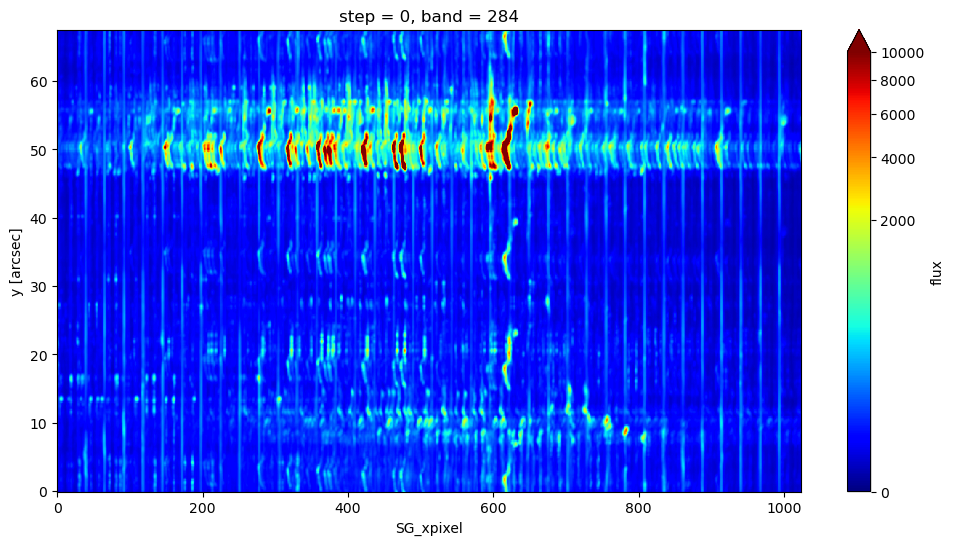

In [30]:
specsum_psf.flux.isel(step=0,band=2).plot.imshow(norm=colors.PowerNorm(0.3), cmap='jet', figsize=(12,6),vmin=0,vmax=1e4)

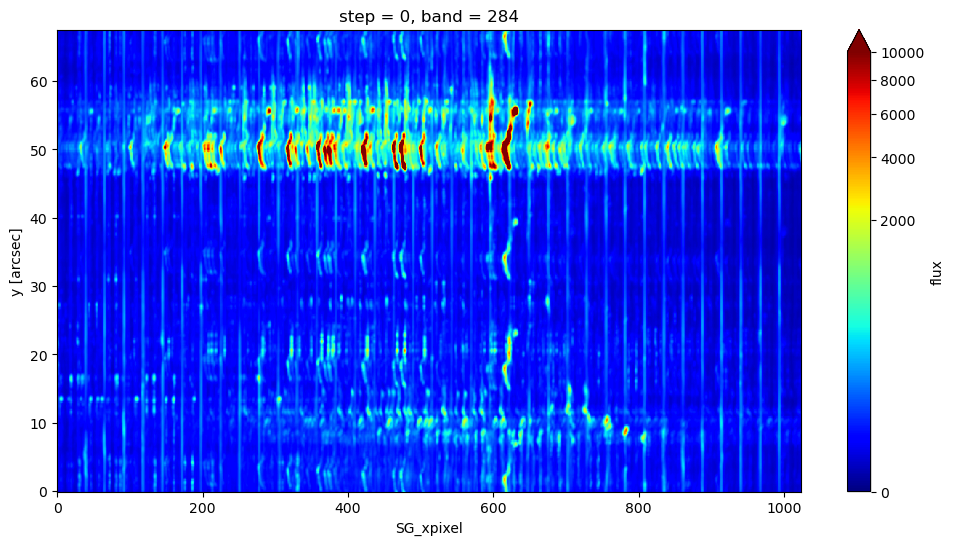

In [31]:
spec_psf_a.flux.isel(step=0,band=2).plot.imshow(norm=colors.PowerNorm(0.3), cmap='jet', figsize=(12,6),vmin=0,vmax=1e4)

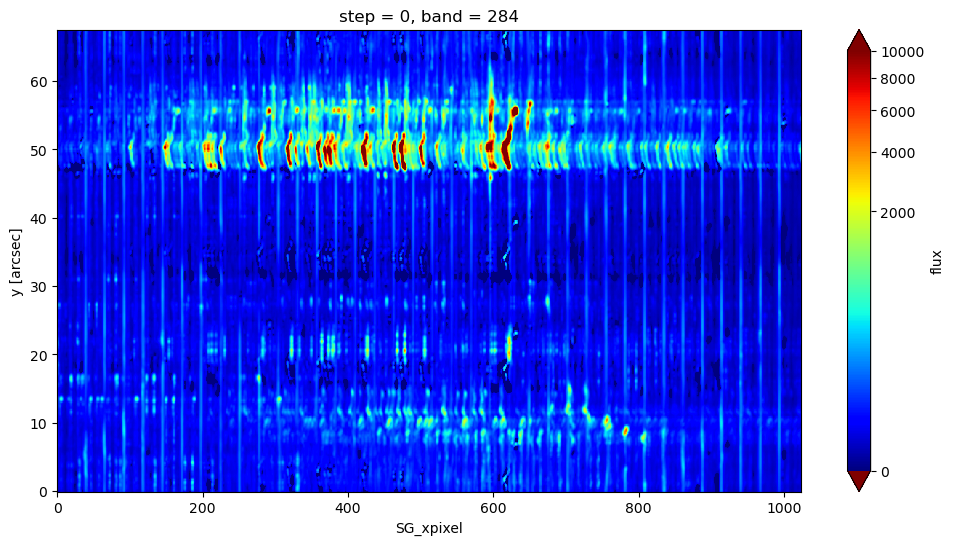

In [32]:
spec2_psf_a.flux.isel(step=0,band=2).plot.imshow(norm=colors.PowerNorm(0.3), cmap='jet', figsize=(12,6),vmin=0,vmax=1e4)

In [33]:
# Disambiguation without any trick on the diffraction. 
func_list = [
    # preparing response function  (summing lines)
    "respsum & sum_lines_per_band(resp)",
    "respsum.SG_resp & respsum.SG_resp*0.81**2",
    # preparing for disambiguation (some normalization between bands)
    "spec, respsum & weight_func(spec, respsum, fact = {0: 0.10, 1: 5., 2: 2.})", 
    # disambiguation
    "sol & vdem_solve(spec, respsum, model = LassoLars(alpha=1.e-3, fit_intercept=True, normalize=True, eps=np.finfo(float).eps))",
    # remove the normalization between bands
    "spec, respsum, sol & deweight_func(spec, respsum, sol, fact = {0: 0.10, 1: 5., 2: 2.})",
]
spec3_psf_a, resp3_a, sol3_psf_a = adrian_apprach(spec2_psf_a, response, func_list)

0
respsum & sum_lines_per_band(resp)
respsum.SG_resp & respsum.SG_resp*0.81**2
spec, respsum & weight_func(spec, respsum, fact = {0: 0.10, 1: 5., 2: 2.})
5.982097895286842e+32 <xarray.DataArray 'SG_resp' ()>
array(9.7431755, dtype=float32)
Coordinates:
    band     int64 284
sol & vdem_solve(spec, respsum, model = LassoLars(alpha=1.e-3, fit_intercept=True, normalize=True, eps=np.finfo(float).eps))


100%|██████████| 4444/4444 [5:07:51<00:00,  4.16s/it]  


spec, respsum, sol & deweight_func(spec, respsum, sol, fact = {0: 0.10, 1: 5., 2: 2.})
1196419.5790573684 <xarray.DataArray 'SG_resp' ()>
array(19.486351, dtype=float32)
Coordinates:
    band     int64 284


In [ ]:
spec3_psf_a

In [ ]:
respsum = sum_lines_per_band(response)
respsum.sel(band=284)["SG_resp"] = respsum.sel(band=284).SG_resp*0.81**2

In [ ]:
os.chdir('juan')
#spec = xr.open_zarr("spec.zarr", consolidated=True)
#spec_dec = xr.open_zarr("spec_dec.zarr", consolidated=True)
#resp = xr.open_zarr("resp.zarr", consolidated=True)
#sol = xr.open_zarr("sol.zarr", consolidated=True)
spec_psf_a = xr.open_zarr("spec_psf_a.zarr", consolidated=True)
resp_a = xr.open_zarr("resp_a.zarr", consolidated=True)
sol_psf_a = xr.open_zarr("sol_psf_a.zarr", consolidated=True)
#spec2_psf_a = xr.open_zarr("spec2_psf_a.zarr", consolidated=True)
#resp2_a = xr.open_zarr("resp2_a.zarr", consolidated=True)
#sol2_psf_a = xr.open_zarr("sol2_psf_a.zarr", consolidated=True)
#spec3_psf_a = xr.open_zarr("spec3_psf_a.zarr", consolidated=True)
#resp3_a = xr.open_zarr("resp2_a.zarr", consolidated=True)
#sol3_psf_a = xr.open_zarr("sol3_psf_a.zarr", consolidated=True)
#specsum_psf = xr.open_zarr("specsum_psf.zarr", consolidated=True)
#specsum = xr.open_zarr("specsum.zarr", consolidated=True)
#respsum = xr.open_zarr("respsum.zarr", consolidated=True)

In [34]:
# Compute some "fake" diffraction pattern and substract from the original data. 
func_list = [
    # synthesize as a function of wvl (no spectrograph)
    "spec & vdem_syn_join_slits_wvl(resp, sol)",    
    # obtain the diffraction pattern in the spectrum (I*PSF/(90%^2) - I), i.e., diffraction pattern in spectrum, 
    "diff_pat & convolve_model_psf(spec, model=gausslobes,**{'oversample_x': 3, 'slit_dim': 404}, band=[284], no_core=[True])", # only spikes 
    # MUSE stuff on the diffraction pattern, i.e., slits, raster, etc. 
    #diff_at *= 1.62 = 1/T**2
    "diff_pat, resp & muse_interp_xyw2rssg(diff_pat, resp)", 
    # MUSE Sum slits and contaminants for the diffraction pattern
    "diff_pat & sum_lines_slits_per_band(diff_pat)",
    # Adrians trick: Spec(orig) - diffraction pattern
    "spec & sub_possitive(spec_orig, diff_pat)", 
]
spec4_psf_a, resp4_a, sol4_psf_a = adrian2_apprach(spec3_psf_a, response, sol3_psf_a, specsum_psf, func_list)


0
spec & vdem_syn_join_slits_wvl(resp, sol)
diff_pat & convolve_model_psf(spec, model=gausslobes,**{'oversample_x': 3, 'slit_dim': 404}, band=[284], no_core=[True])
diff_pat, resp & muse_interp_xyw2rssg(diff_pat, resp)
diff_pat & sum_lines_slits_per_band(diff_pat)
spec & sub_possitive(spec_orig, diff_pat)


In [22]:
spec2_psf_a

<xarray.Dataset>
Dimensions:    (SG_xpixel: 1024, band: 3, step: 11, y: 404)
Coordinates:
  * SG_xpixel  (SG_xpixel) int32 0 1 2 3 4 5 6 ... 1018 1019 1020 1021 1022 1023
  * band       (band) int64 108 171 284
  * step       (step) int64 0 1 2 3 4 5 6 7 8 9 10
  * y          (y) float64 0.0 0.1674 0.3348 0.5022 ... 66.97 67.13 67.3 67.47
Data variables:
    flux       (band, step, y, SG_xpixel) float64 dask.array<chunksize=(1, 3, 101, 512), meta=np.ndarray>
    line_wvl   (band) float64 dask.array<chunksize=(3,), meta=np.ndarray>
Attributes: (12/20)
    ABUNDANCES:       sun_coronal_1992_feldman_ext.abund
    BAND_CUBES:       band_cubes_569lines_p3e15_coronal_to2000kms-26Mar2021.sav
    DESCRIPTION:      test
    EFF_AREA:         SMX00044 muse_response_20160811.sav
    E_PRESSURE:       3000000028082176.0
    GOFT_FILE:        goft_p3e15-6Mar2021.sav
    ...               ...
    UNITS:            photon counts/s from EM=10^27(cm^-5) at Log10(T/K), VDO...
    VERSION:          made using muse-v1f.pro, Fri Mar 26 20:01:03 2021, mult...
    flux units:       ph/s
    step_size:        0.4009852216748769
    step_size units:  arcsec
    version:          0.1.dev10+ge741e21

In [31]:
print(os.getcwd())
spec2_psf_a.to_zarr("spec2_psf_a.zarr")




/mnt/disks/disk-6-kyuhyoun/juan


In [21]:
# os.chdir('juan')
#spec_dec.to_zarr("spec_dec.zarr")
#spec.to_zarr("spec.zarr")
#resp.to_zarr("resp.zarr")
#sol.to_zarr("sol.zarr")
# spec_psf_a.to_zarr("spec_psf_a.zarr")
# resp_a.to_zarr("resp_a.zarr")
# sol_psf_a.to_zarr("sol_psf_a.zarr")
spec2_psf_a.to_zarr("spec2_psf_a.zarr")
resp2_a.to_zarr("resp2_a.zarr")
sol2_psf_a.to_zarr("sol2_psf_a.zarr")
# specsum_psf.to_zarr("specsum_psf.zarr")
# specsum.to_zarr("specsum.zarr")
# respsum.to_zarr("respsum.zarr")

ContainsGroupError: path '' contains a group

In [36]:
#spec2_psf_a.to_zarr("spec2_psf_a.zarr")
#resp2_a.to_zarr("resp2_a.zarr")
#sol2_psf_a.to_zarr("sol2_psf_a.zarr")
spec3_psf_a.to_zarr("spec3_psf_a.zarr")
#resp3_a.to_zarr("resp3_a.zarr")
sol3_psf_a.to_zarr("sol3_psf_a.zarr")
spec4_psf_a.to_zarr("spec4_psf_a.zarr")
#resp4_a.to_zarr("resp4_a.zarr")
sol4_psf_a.to_zarr("sol4_psf_a.zarr")

In [37]:
#spec = xr.open_zarr("spec.zarr", consolidated=True)
#spec_dec = xr.open_zarr("spec_dec.zarr", consolidated=True)
#resp = xr.open_zarr("resp.zarr", consolidated=True)
#sol = xr.open_zarr("sol.zarr", consolidated=True)
#spec_psf_a = xr.open_zarr("spec_psf_a.zarr", consolidated=True)
#resp_a = xr.open_zarr("resp_a.zarr", consolidated=True)
#sol_psf_a = xr.open_zarr("sol_psf_a.zarr", consolidated=True)
spec_psf_a = xr.open_zarr("spec2_psf_a.zarr", consolidated=True)
resp_a = xr.open_zarr("resp2_a.zarr", consolidated=True)
sol_psf_a = xr.open_zarr("sol2_psf_a.zarr", consolidated=True)
spec4_psf_a = xr.open_zarr("spec4_psf_a.zarr", consolidated=True)
resp4_a = xr.open_zarr("resp4_a.zarr", consolidated=True)
sol4_psf_a = xr.open_zarr("sol4_psf_a.zarr", consolidated=True)
#specsum_psf = xr.open_zarr("specsum_psf.zarr", consolidated=True)
#specsum = xr.open_zarr("specsum.zarr", consolidated=True)
#respsum = xr.open_zarr("respsum.zarr", consolidated=True)

KeyError: '.zmetadata'

In [ ]:
specsum_psf = xr.open_zarr("specsum_psf.zarr", consolidated=True)

In [ ]:
step=0

In [ ]:
specsum_psf.flux.isel(step=step,band=2).plot.imshow(norm=colors.PowerNorm(0.3), cmap='jet', figsize=(12,6),vmin=0,vmax=1e4)

In [ ]:
spec4_psf_a.flux.isel(step=step,band=2).plot.imshow(norm=colors.PowerNorm(0.3), cmap='jet', figsize=(12,6),vmin=0,vmax=1e4)

In [ ]:
specsum_only_core.flux.isel(step=0,band=2).plot.imshow(norm=colors.PowerNorm(0.3), cmap='jet', figsize=(12,6),vmin=0,vmax=1e4)

In [ ]:
muse_spect.flux.isel(step=7,band=2).sum(dim=['slit']).plot.imshow(norm=colors.PowerNorm(0.3), cmap='jet', figsize=(12,6),vmin=0,vmax=1e4)

In [ ]:
(specsum_only_core.flux.sel(band=284,step=step)-spec4_psf_a.flux.sel(band=284,step=step)).plot.imshow(cmap='bwr', figsize=(12,6),vmin=-1e2,vmax=1e2)

In [ ]:
print((np.abs(specsum_only_core.flux.sel(band=284,step=step)-spec2_psf_a.flux.sel(band=284,step=step))).sum().to_numpy())
print((np.abs(specsum_only_core.flux.sel(band=284,step=step)-spec4_psf_a.flux.sel(band=284,step=step))).sum().to_numpy())

In [ ]:
(specsum_only_core.flux.sel(band=284,step=step)-spec2_psf_a.flux.sel(band=284,step=step)).plot.imshow(cmap='bwr', figsize=(12,6),vmin=-1e2,vmax=1e2)

In [ ]:
speca3_psf_a = vdem_syn_join_slits_wvl(resp_a, sol2_psf_a)
speca3_psf_a

In [ ]:
spec2_psf_a.flux.isel(step=0,band=2).plot.imshow(norm=colors.PowerNorm(0.3), cmap='jet', figsize=(12,6),vmin=0,vmax=1e4)

In [ ]:
specsum_only_core.flux.isel(step=0,band=1).plot.imshow(norm=colors.PowerNorm(0.3), cmap='jet', figsize=(12,6),vmin=0,vmax=1e4)

In [ ]:
spec_108171 = vdem_syn_join_slits_wvl(response, sol_psf_a)
spec_core_108171 = convolve_model_psf(spec_108171, model=gausslobes,**{'oversample_x': 3, 'slit_dim': 404}, band=[108,171], only_core=True)
muse_spec_core_108171, resp = muse_interp_xyw2rssg(spec_core_108171, response)
spec2_108171 = vdem_syn_join_slits_wvl(response, sol3_psf_a)
spec2_core_108171 = convolve_model_psf(spec2_108171, model=gausslobes,**{'oversample_x': 3, 'slit_dim': 404}, band=[108,171], only_core=True)
muse2_spec_core_108171, resp = muse_interp_xyw2rssg(spec2_core_108171, response)

In [ ]:
muse2_spec_core_108171=muse2_spec_core_108171.sum(dim=['slit'])
muse_spec_core_108171=muse_spec_core_108171.sum(dim=['slit'])
muse_spec_core_108171

In [ ]:
muse_spec_core_108171.flux.isel(band=1,step=0).sum(dim=['slit']).plot.imshow(vmin=0,vmax=1e3)

In [ ]:
spec_psf_a

In [ ]:
print((np.abs(specsum_only_core.flux.sel(band=0)-spec2_psf_a.flux.sel(band=0))).sum().to_numpy())

In [ ]:
fig01, ax01 = plt.subplots(3, 3, figsize=(12, 10))
bins = np.linspace(1, 6, 50)
for i in range(3):
    for j in range(3):
        if j == 0 : spec_obj, ylabel = spec_psf_a, 'with PSF'
        if i < 2: 
            if j == 1 : spec_obj, ylabel = muse_spec_core_108171, '1st iteration'
            if j == 2 : spec_obj, ylabel = muse2_spec_core_108171, '2nd iteration'            
        else: 
            if j == 1 : spec_obj, ylabel = spec2_psf_a, '1st iteration'
            if j == 2 : spec_obj, ylabel = spec4_psf_a, '2nd iteration'
            
        hist1 = histogram(np.log10(spec_obj.flux.isel(band=i)), 
                          np.log10(specsum_only_core.flux.isel(band=i)), 
                          bins=[bins, bins])
        hist1.plot.imshow(ax=ax01[i, j], norm=colors.LogNorm(1, 1e3), cmap='jet')
        ax01[i, j].text(1,5,'%i'%int((np.abs(specsum_only_core.flux.isel(band=i)-spec_obj.flux.isel(band=i))).sum().to_numpy()))
        ax01[i, j].plot(bins, bins, alpha=0.5)
        ax01[i, j].set_title(specsum_only_core.band[i].item())
        ax01[i, j].set_xlabel('No PSF')
        ax01[i, j].set_ylabel(ylabel)
        #ax01[i, j].text(1.1, 5.7, 
        #                f'{np.log10(abs((specsum_only_core.flux-spec_obj.flux)).isel(band=i).sum().item()):.3f}')
plt.tight_layout()

In [ ]:
spec4_psf_a

In [ ]:
spec_inv_psf = vdem_synthesis(sol_psf_d, response, sum_over=['logT', 'vdop']) #add 'slit' to sum_over to collapse over slits
spec = vdem_synthesis(vdem3, response, sum_over=['logT', 'vdop']) #add 'slit' to sum_over to collapse over slits

In [ ]:
help(LassoLars)

In [ ]:
%%time
# 13A -> F14B: Compute spectra for each slit all lines (separately)
spec1st = vdem_synthesis(sol_psf_a, response, sum_over=['logT', 'vdop']) #add 'slit' to sum_over to collapse over slits
spec2nd = vdem_synthesis(sol3_psf_a, response, sum_over=['logT', 'vdop']) #add 'slit' to sum_over to collapse over slits
specsyn = vdem_synthesis(vdem3, response, sum_over=['logT', 'vdop']) #add 'slit' to sum_over to collapse over slits

In [ ]:
specsyn=specsyn.swap_dims({"band":"line"})

In [ ]:
spec1st=spec1st.swap_dims({"band":"line"})

In [ ]:
spec2nd=spec2nd.swap_dims({"band":"line"})

In [ ]:
(specsyn - spec1st).flux.sel(line='Fe XV',step=0).sum("slit").plot.imshow(norm=colors.PowerNorm(0.3,vmin=-1e3,vmax=1e3), cmap='bwr', figsize=(12,6))

In [ ]:
specsyn.flux.sel(line='Fe XV',step=0).sum("slit").plot.imshow(norm=colors.PowerNorm(0.3,vmin=0,vmax=1e2), cmap='jet', figsize=(12,6))
spec1st.flux.sel(line='Fe XV',step=0).sum("slit").plot.imshow(norm=colors.PowerNorm(0.3,vmin=0,vmax=1e2), cmap='jet', figsize=(12,6))
spec2nd.flux.sel(line='Fe XV',step=0).sum("slit").plot.imshow(norm=colors.PowerNorm(0.3,vmin=0,vmax=1e2), cmap='jet', figsize=(12,6))

In [ ]:
%%time
# MUSE requirements are on Doppler velocities and line widths. 
momsyn=calculate_moments(specsyn,moment_dim='SG_xpixel',vmax=300,label='orig')
# The synthesis of the disambiguated model is in raster & slits which we need to change to x-axis. 
momsyn_x = reshape_rs2x(momsyn)
mom1st=calculate_moments(spec1st,moment_dim='SG_xpixel',vmax=100,label='1st')
# The synthesis of the disambiguated model is in raster & slits which we need to change to x-axis. 
mom1st_x = reshape_rs2x(mom1st)
# Sampling the box to get results faster. 
mom2nd=calculate_moments(spec2nd,moment_dim='SG_xpixel',label='2nd')
mom2nd_x = reshape_rs2x(mom2nd)

In [ ]:
try: 
    momsyn=momsyn.swap_dims({"band": "line"})
except: 
    print('maybe band is not there and already line is the main coord') 

In [ ]:
momsyn.to_zarr("momsyn_NOnormalize_NOfit_intercept")
mominv_x.to_zarr("mominv_x_NOnormalize_NOfit_intercept")
mominv_psf_x.to_zarr("mominv_psf_NOnormalize_NOfit_intercept")
spec.to_zarr("spec_NOnormalize_NOfit_intercept")
spec_inv_psf.to_zarr("spec_inv_psf_NOnormalize_NOfit_intercept")
spec_inv.to_zarr("spec_inv_NOnormalize_NOfit_intercept")
solution_psf.to_zarr("solution_psf_NOnormalize_NOfit_intercept")
solution.to_zarr("solution_NOnormalize_NOfit_intercept")

In [ ]:
mom2nd_x

In [ ]:
plt.figure(figsize=(15,5))
namelistinv=['0th 1st mom', '1st 1st mom', '2nd 1st mom']
namelistinvpsf=['0th 2nd mom', '1st 2nd mom', '2nd 2nd mom']
namelistobs=['0th orig mom', '1st orig mom', '2nd orig mom']
line='Fe XV'
plt.figure(figsize=(16,10))
plt.subplot(3,3,1)
momsyn_x[namelistobs[0]].sel(line=line).plot.imshow(norm=colors.PowerNorm(0.3,vmin=0,vmax=1e6),cmap='jet')
plt.subplot(3,3,2)
momsyn_x[namelistobs[1]].sel(line=line).plot.imshow(vmin=-100,vmax=100,cmap='bwr')
plt.subplot(3,3,3)
momsyn_x[namelistobs[2]].sel(line=line).plot.imshow(vmin=30,vmax=50)
plt.subplot(3,3,4)
mom1st_x[namelistinv[0]].sel(line=line).plot.imshow(norm=colors.PowerNorm(0.3,vmin=0,vmax=1e6),cmap='jet')
plt.subplot(3,3,5)
mom1st_x[namelistinv[1]].sel(line=line).plot.imshow(vmin=-100,vmax=100,cmap='bwr')
plt.subplot(3,3,6)
mom1st_x[namelistinv[2]].sel(line=line).plot.imshow(vmin=30,vmax=50)
plt.subplot(3,3,7)
mom2nd_x[namelistinvpsf[0]].sel(line=line).plot.imshow(norm=colors.PowerNorm(0.3,vmin=0,vmax=1e6),cmap='jet')
plt.subplot(3,3,8)
mom2nd_x[namelistinvpsf[1]].sel(line=line).plot.imshow(vmin=-100,vmax=100,cmap='bwr')
plt.subplot(3,3,9)
mom2nd_x[namelistinvpsf[2]].sel(line=line).plot.imshow(vmin=30,vmax=50)
plt.tight_layout()

In [ ]:
momsyn

In [ ]:
plt.figure(figsize=(15,5))
line='Fe XV is missing'
plt.figure(figsize=(12,15))
ax=plt.subplot(3,1,1)
momsyn_x[namelistobs[0]].sel(line=line).plot.imshow(norm=colors.PowerNorm(0.3,vmin=0,vmax=1e2),cmap='jet')
plt.title('No PSF, '+line)
plt.subplot(3,1,2)
mom2nd_x[namelistinvpsf[0]].sel(line=line).plot.imshow(norm=colors.PowerNorm(0.3,vmin=0,vmax=1e2),cmap='jet')
plt.title('With PSF, '+line)
plt.subplot(3,1,3)
diff=(momsyn_x[namelistobs[0]]-mom2nd_x[namelistinvpsf[0]])/(momsyn_x[namelistobs[0]]+mom2nd_x[namelistinvpsf[0]])
diff.sel(line=line).plot.imshow(vmin=-1,vmax=1,cmap='bwr')
plt.title('(No PSF - PSF)/((No PSF + PSF)), '+line)

In [ ]:
fig,axs = plt.subplots(3,5, figsize = (20,10.5))
linelist=['Fe IX','Fe XV','Fe XIX']
for ilist,line in enumerate(linelist): 
    inti=np.linspace(1.,6.,50)
    hts1=histogram(np.log10(momsyn_x[namelistobs[0]].sel(line=line)),
        np.log10(mom1st_x[namelistinv[0]].sel(line=line)),
        bins=[inti,inti])
    hts1.plot.imshow(ax=axs[ilist,0],norm=colors.LogNorm(vmin=1e-1,vmax=1e3),cmap='jet')
    axs[ilist,0].plot(inti,inti)

    vel=np.linspace(-60.,60.,50)
    hts2=histogram(momsyn_x[namelistobs[1]].sel(line=line),
        mom1st_x[namelistinv[1]].sel(line=line),
        bins=[vel,vel])
    hts2.plot.imshow(ax=axs[ilist,1],norm=colors.LogNorm(vmin=1e-1,vmax=1e3),cmap='jet')
    axs[ilist,1].plot(vel,vel)
    
    diff=momsyn_x[namelistobs[1]].sel(line=line)-mom1st_x[namelistinv[1]].sel(line=line)
    diff = diff.rename('diff 1st mom')
    vel=np.linspace(-30.,30.,50)
    hts2=histogram(diff,
        np.log10(mom1st_x[namelistinv[0]].sel(line=line)),
        bins=[vel,inti])
    hts2.plot.imshow(ax=axs[ilist,2],norm=colors.LogNorm(vmin=1e-1,vmax=1e3),cmap='jet')

    wid=np.linspace(20.,60.,50)
    hts3=histogram(momsyn_x[namelistobs[2]].sel(line=line),
        mom1st_x[namelistinv[2]].sel(line=line),
        bins=[wid,wid])
    hts3.plot.imshow(ax=axs[ilist,3],norm=colors.LogNorm(vmin=1e-1,vmax=1e3),cmap='jet')
    axs[ilist,3].plot(wid,wid)
    
    diff=momsyn_x[namelistobs[2]].sel(line=line)-mom1st_x[namelistinv[2]].sel(line=line)
    diff = diff.rename('diff 1st mom')
    diffw=np.linspace(-30.,30.,50)
    hts2=histogram(diff,
        np.log10(mom1st_x[namelistinv[0]].sel(line=line)),
        bins=[diffw,inti])
    hts2.plot.imshow(ax=axs[ilist,4],norm=colors.LogNorm(vmin=1e-1,vmax=1e3),cmap='jet')
for ii in range(5): 
    axs[0,ii].set_title('without PSF')
fig.tight_layout()

In [ ]:
fig,axs = plt.subplots(3,5, figsize = (20,10.5))
linelist=['Fe IX','Fe XV','Fe XIX']
for ilist,line in enumerate(linelist): 
    inti=np.linspace(1.,6.,50)
    hts1=histogram(np.log10(momsyn_x['0th orig mom'].sel(line=line)),
        np.log10(mom2nd_x[namelistinvpsf[0]].sel(line=line)),
        bins=[inti,inti])
    hts1.plot.imshow(ax=axs[ilist,0],norm=colors.LogNorm(vmin=1e-1,vmax=1e3),cmap='jet')
    axs[ilist,0].plot(inti,inti)

    vel=np.linspace(-60.,60.,50)
    hts2=histogram(momsyn_x['1st orig mom'].sel(line=line),
        mom2nd_x[namelistinvpsf[1]].sel(line=line),
        bins=[vel,vel])
    hts2.plot.imshow(ax=axs[ilist,1],norm=colors.LogNorm(vmin=1e-1,vmax=1e3),cmap='jet')
    axs[ilist,1].plot(vel,vel)
    
    diff=momsyn_x['1st orig mom'].sel(line=line)-mom2nd_x[namelistinvpsf[1]].sel(line=line)
    diff = diff.rename('diff 1st mom')
    vel=np.linspace(-30.,30.,50)
    hts2=histogram(diff,
        np.log10(mom2nd_x[namelistinvpsf[0]].sel(line=line)),
        bins=[vel,inti])
    hts2.plot.imshow(ax=axs[ilist,2],norm=colors.LogNorm(vmin=1e-1,vmax=1e3),cmap='jet')

    wid=np.linspace(20.,60.,50)
    hts3=histogram(momsyn_x['2nd orig mom'].sel(line=line),
        mom2nd_x[namelistinvpsf[2]].sel(line=line),
        bins=[wid,wid])
    hts3.plot.imshow(ax=axs[ilist,3],norm=colors.LogNorm(vmin=1e-1,vmax=1e3),cmap='jet')
    axs[ilist,3].plot(wid,wid)
    
    diff=momsyn_x['2nd orig mom'].sel(line=line)-mom2nd_x[namelistinvpsf[2]].sel(line=line)
    diff = diff.rename('diff 1st mom')
    diffw=np.linspace(-30.,30.,50)
    hts2=histogram(diff,
        np.log10(mom2nd_x[namelistinvpsf[0]].sel(line=line)),
        bins=[diffw,inti])
    hts2.plot.imshow(ax=axs[ilist,4],norm=colors.LogNorm(vmin=1e-1,vmax=1e3),cmap='jet')
for ii in range(5): 
    axs[0,ii].set_title('with PSF')
fig.tight_layout()

## For MUSE we aim to remove contaminants and confusion instead of analyzing the disambiguated main lines.

In [ ]:
spec1st

In [ ]:
# The whole thing of Substraction of contaminants for all band. This will be moved to muse.py
spec1st_sub171=spec2_psf_a.flux.sel(band=171, drop=True)-spec1st.flux.sel(line='Fe IX is missing').sum('slit')
spec1st_sub284=spec2_psf_a.flux.sel(band=284, drop=True)-spec1st.flux.sel(line='Fe XIX is missing').sum('slit')
spec1st_sub108=spec2_psf_a.flux.sel(band=108, drop=True)-spec1st.flux.sel(line='Fe XV is missing').sum('slit')


In [ ]:
spec1st_sub284

In [ ]:
spec_sub2 = xr.Dataset()
spec_sub2['flux'] = spec1st_sub171
spec_sub3 = spec_sub2.expand_dims({'line':3}).copy()
spec_sub3.update({"line": ("line", ['Fe IX','Fe XV', 'Fe XIX'])})
print(spec_sub3)
spec_sub3=spec_sub3.copy(deep=True)
spec_sub3['flux'].loc[dict(line='Fe XV')]=spec1st_sub284
spec_sub3.flux.loc[dict(line='Fe XIX')]=spec1st_sub108
spec_sub3 = spec_sub3.expand_dims({'slit':37})
spec_sub3['vdop'] = spec1st['vdop']
spec_sub3['SG_wvl'] = spec1st['SG_wvl']
spec_sub3['line_wvl'] = spec1st['line_wvl']


In [ ]:
momsub=calculate_moments(spec_sub3,moment_dim='SG_xpixel',vmax=200,label='sub')
momsub.attrs.update({"step_size": 0.4})
momsub=reshape_rs2x(momsub)

In [ ]:
fig,axs = plt.subplots(3,2, figsize = (20,10.5))
line='Fe IX'
momsyn_x[namelistobs[0]].sel(line=line).plot.imshow(ax=axs[0,0],norm=colors.PowerNorm(0.3,vmin=0,vmax=1e5),cmap='jet')
momsub['0th sub mom'].sel(line=line).plot.imshow(ax=axs[0,1],norm=colors.PowerNorm(0.3,vmin=0,vmax=1e5),cmap='jet')
momsyn_x[namelistobs[1]].sel(line=line).plot.imshow(ax=axs[1,0],vmin=-200,vmax=200,cmap='bwr')#vmin=0,vmax=1e-25)
momsub['1st sub mom'].sel(line=line).plot.imshow(ax=axs[1,1],vmin=-200,vmax=200,cmap='bwr')
momsyn_x[namelistobs[2]].sel(line=line).plot.imshow(ax=axs[2,0],cmap='jet',vmin=0,vmax=80)
momsub['2nd sub mom'].sel(line=line).plot.imshow(ax=axs[2,1],vmin=0,vmax=80,cmap='jet')

In [ ]:
fig,axs = plt.subplots(3,2, figsize = (20,10.5))
line='Fe XV'
momsyn_x[namelistobs[0]].sel(line=line).plot.imshow(ax=axs[0,0],norm=colors.PowerNorm(0.3,vmin=0,vmax=1e5),cmap='jet')
momsub['0th sub mom'].sel(line=line).plot.imshow(ax=axs[0,1],norm=colors.PowerNorm(0.3,vmin=0,vmax=1e5),cmap='jet')
momsyn_x[namelistobs[1]].sel(line=line).plot.imshow(ax=axs[1,0],vmin=-200,vmax=200,cmap='bwr')#vmin=0,vmax=1e-25)
momsub['1st sub mom'].sel(line=line).plot.imshow(ax=axs[1,1],vmin=-200,vmax=200,cmap='bwr')
momsyn_x[namelistobs[2]].sel(line=line).plot.imshow(ax=axs[2,0],cmap='jet',vmin=0,vmax=80)
momsub['2nd sub mom'].sel(line=line).plot.imshow(ax=axs[2,1],vmin=0,vmax=80,cmap='jet')

In [ ]:
fig,axs = plt.subplots(3,2, figsize = (20,10.5))
line='Fe XIX'
momsyn_x[namelistobs[0]].sel(line=line).plot.imshow(ax=axs[0,0],norm=colors.PowerNorm(0.3,vmin=0,vmax=1e5),cmap='jet')
momsub['0th sub mom'].sel(line=line).plot.imshow(ax=axs[0,1],norm=colors.PowerNorm(0.3,vmin=0,vmax=1e5),cmap='jet')
momsyn_x[namelistobs[1]].sel(line=line).plot.imshow(ax=axs[1,0],vmin=-200,vmax=200,cmap='bwr')#vmin=0,vmax=1e-25)
momsub['1st sub mom'].sel(line=line).plot.imshow(ax=axs[1,1],vmin=-200,vmax=200,cmap='bwr')
momsyn_x[namelistobs[2]].sel(line=line).plot.imshow(ax=axs[2,0],cmap='jet',vmin=0,vmax=80)
momsub['2nd sub mom'].sel(line=line).plot.imshow(ax=axs[2,1],vmin=0,vmax=80,cmap='jet')

In [ ]:
momsyn_x['0th orig mom'].sel(line=line)

In [ ]:
print(momsyn_x.coords['x'])
momsub.coords['x']=momsyn_x.coords['x']

In [ ]:
fig,axs = plt.subplots(3,5, figsize = (20,10))
linelist=['Fe IX','Fe XV','Fe XIX']

for ilist,line in enumerate(linelist): 
    inti=np.linspace(1.,6.,50)
    hts1=histogram(np.log10(momsyn_x['0th orig mom'].sel(line=line)),
        np.log10(momsub['0th sub mom'].sel(line=line)),
        bins=[inti,inti])
    hts1.plot.imshow(ax=axs[ilist,0],norm=colors.LogNorm(vmin=1e-1,vmax=1e3),cmap='jet')
    axs[ilist,0].plot(inti,inti)

    vel=np.linspace(-60.,60.,50)
    hts2=histogram(momsyn_x['1st orig mom'].sel(line=line),
        momsub['1st sub mom'].sel(line=line),
        bins=[vel,vel])
    hts2.plot.imshow(ax=axs[ilist,1],norm=colors.LogNorm(vmin=1e-1,vmax=1e3),cmap='jet')
    axs[ilist,1].plot(vel,vel)

    diff=momsyn_x['1st orig mom'].sel(line=line)-momsub['1st sub mom'].sel(line=line)
    diff = diff.rename('diff 1st mom')
    vel=np.linspace(-30.,30.,50)
    hts2=histogram(diff,
        np.log10(momsub['0th sub mom']),
        bins=[vel,inti])
    hts2.plot.imshow(ax=axs[ilist,2],norm=colors.LogNorm(vmin=1e-1,vmax=1e3),cmap='jet')

    wid=np.linspace(20.,60.,50)
    hts3=histogram(momsyn_x['2nd orig mom'].sel(line=line),
        momsub['2nd sub mom'].sel(line=line),
        bins=[wid,wid])
    hts3.plot.imshow(ax=axs[ilist,3],norm=colors.LogNorm(vmin=1e-1,vmax=1e3),cmap='jet')
    axs[ilist,3].plot(wid,wid)

    diff=momsyn_x['2nd orig mom'].sel(line=line)-momsub['2nd sub mom'].sel(line=line)
    diff = diff.rename('diff 1st mom')
    diffw=np.linspace(-30.,30.,50)
    hts2=histogram(diff,
        np.log10(momsub['0th sub mom'].sel(line=line)),
        bins=[diffw,inti])
    hts2.plot.imshow(ax=axs[ilist,4],norm=colors.LogNorm(vmin=1e-1,vmax=1e3),cmap='jet')
fig.tight_layout()

In [ ]:
# The whole thing of Substraction of contaminants for all band. This will be moved to muse.py
spec2nd_sub171=spec4_psf_a.flux.sel(band=171, drop=True)-spec2nd.flux.sel(line='Fe IX is missing').sum('slit')
spec2nd_sub284=spec4_psf_a.flux.sel(band=284, drop=True)-spec2nd.flux.sel(line='Fe XIX is missing').sum('slit')
spec2nd_sub108=spec4_psf_a.flux.sel(band=108, drop=True)-spec2nd.flux.sel(line='Fe XV is missing').sum('slit')


In [ ]:
spec_sub2 = xr.Dataset()
spec_sub2['flux'] = spec2nd_sub171
spec_sub3 = spec_sub2.expand_dims({'line':3}).copy()
spec_sub3.update({"line": ("line", ['Fe IX','Fe XV', 'Fe XIX'])})
spec_sub3=spec_sub3.copy(deep=True)
spec_sub3['flux'].loc[dict(line='Fe XV')]=spec2nd_sub284
spec_sub3.flux.loc[dict(line='Fe XIX')]=spec2nd_sub108
spec_sub3 = spec_sub3.expand_dims({'slit':37})
spec_sub3['vdop'] = spec2nd['vdop']
spec_sub3['SG_wvl'] = spec2nd['SG_wvl']
spec_sub3['line_wvl'] = spec2nd['line_wvl']

In [ ]:
momsub=calculate_moments(spec_sub3,moment_dim='SG_xpixel',vmax=200,label='sub')
momsub.attrs.update({"step_size": 0.4})
momsub=reshape_rs2x(momsub)

In [ ]:
fig,axs = plt.subplots(3,2, figsize = (20,10.5))
line='Fe IX'
momsyn_x[namelistobs[0]].sel(line=line).plot.imshow(ax=axs[0,0],norm=colors.PowerNorm(0.3,vmin=0,vmax=1e5),cmap='jet')
momsub['0th sub mom'].sel(line=line).plot.imshow(ax=axs[0,1],norm=colors.PowerNorm(0.3,vmin=0,vmax=1e5),cmap='jet')
momsyn_x[namelistobs[1]].sel(line=line).plot.imshow(ax=axs[1,0],vmin=-200,vmax=200,cmap='bwr')#vmin=0,vmax=1e-25)
momsub['1st sub mom'].sel(line=line).plot.imshow(ax=axs[1,1],vmin=-200,vmax=200,cmap='bwr')
momsyn_x[namelistobs[2]].sel(line=line).plot.imshow(ax=axs[2,0],cmap='jet',vmin=0,vmax=80)
momsub['2nd sub mom'].sel(line=line).plot.imshow(ax=axs[2,1],vmin=0,vmax=80,cmap='jet')

In [ ]:
fig,axs = plt.subplots(3,2, figsize = (20,10.5))
line='Fe XV'
momsyn_x[namelistobs[0]].sel(line=line).plot.imshow(ax=axs[0,0],norm=colors.PowerNorm(0.3,vmin=0,vmax=1e5),cmap='jet')
momsub['0th sub mom'].sel(line=line).plot.imshow(ax=axs[0,1],norm=colors.PowerNorm(0.3,vmin=0,vmax=1e5),cmap='jet')
momsyn_x[namelistobs[1]].sel(line=line).plot.imshow(ax=axs[1,0],vmin=-200,vmax=200,cmap='bwr')#vmin=0,vmax=1e-25)
momsub['1st sub mom'].sel(line=line).plot.imshow(ax=axs[1,1],vmin=-200,vmax=200,cmap='bwr')
momsyn_x[namelistobs[2]].sel(line=line).plot.imshow(ax=axs[2,0],cmap='jet',vmin=0,vmax=80)
momsub['2nd sub mom'].sel(line=line).plot.imshow(ax=axs[2,1],vmin=0,vmax=80,cmap='jet')

In [ ]:
fig,axs = plt.subplots(3,2, figsize = (20,10.5))
line='Fe XIX'
momsyn_x[namelistobs[0]].sel(line=line).plot.imshow(ax=axs[0,0],norm=colors.PowerNorm(0.3,vmin=0,vmax=1e4),cmap='jet')
momsub['0th sub mom'].sel(line=line).plot.imshow(ax=axs[0,1],norm=colors.PowerNorm(0.3,vmin=0,vmax=1e4),cmap='jet')
momsyn_x[namelistobs[1]].sel(line=line).plot.imshow(ax=axs[1,0],vmin=-200,vmax=200,cmap='bwr')#vmin=0,vmax=1e-25)
momsub['1st sub mom'].sel(line=line).plot.imshow(ax=axs[1,1],vmin=-200,vmax=200,cmap='bwr')
momsyn_x[namelistobs[2]].sel(line=line).plot.imshow(ax=axs[2,0],cmap='jet',vmin=0,vmax=80)
momsub['2nd sub mom'].sel(line=line).plot.imshow(ax=axs[2,1],vmin=0,vmax=80,cmap='jet')

In [ ]:
momsub.coords['x']=momsyn_x.coords['x']

In [ ]:
fig,axs = plt.subplots(3,5, figsize = (20,10))
linelist=['Fe IX','Fe XV','Fe XIX']

for ilist,line in enumerate(linelist): 
    inti=np.linspace(1.,6.,50)
    hts1=histogram(np.log10(momsyn_x['0th orig mom'].sel(line=line)),
        np.log10(momsub['0th sub mom'].sel(line=line)),
        bins=[inti,inti])
    hts1.plot.imshow(ax=axs[ilist,0],norm=colors.LogNorm(vmin=1e-1,vmax=1e3),cmap='jet')
    axs[ilist,0].plot(inti,inti)

    vel=np.linspace(-60.,60.,50)
    hts2=histogram(momsyn_x['1st orig mom'].sel(line=line),
        momsub['1st sub mom'].sel(line=line),
        bins=[vel,vel])
    hts2.plot.imshow(ax=axs[ilist,1],norm=colors.LogNorm(vmin=1e-1,vmax=1e3),cmap='jet')
    axs[ilist,1].plot(vel,vel)

    diff=momsyn_x['1st orig mom'].sel(line=line)-momsub['1st sub mom'].sel(line=line)
    diff = diff.rename('diff 1st mom')
    vel=np.linspace(-30.,30.,50)
    hts2=histogram(diff,
        np.log10(momsub['0th sub mom']),
        bins=[vel,inti])
    hts2.plot.imshow(ax=axs[ilist,2],norm=colors.LogNorm(vmin=1e-1,vmax=1e3),cmap='jet')

    wid=np.linspace(20.,60.,50)
    hts3=histogram(momsyn_x['2nd orig mom'].sel(line=line),
        momsub['2nd sub mom'].sel(line=line),
        bins=[wid,wid])
    hts3.plot.imshow(ax=axs[ilist,3],norm=colors.LogNorm(vmin=1e-1,vmax=1e3),cmap='jet')
    axs[ilist,3].plot(wid,wid)

    diff=momsyn_x['2nd orig mom'].sel(line=line)-momsub['2nd sub mom'].sel(line=line)
    diff = diff.rename('diff 1st mom')
    diffw=np.linspace(-30.,30.,50)
    hts2=histogram(diff,
        np.log10(momsub['0th sub mom'].sel(line=line)),
        bins=[diffw,inti])
    hts2.plot.imshow(ax=axs[ilist,4],norm=colors.LogNorm(vmin=1e-1,vmax=1e3),cmap='jet')
fig.tight_layout()